In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import dask.dataframe as dd

import time
import random 

from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style="darkgrid")
current_palette = sns.color_palette()
from IPython.display import Image


In [5]:
pd.options.display.min_rows = 20
pd.options.display.max_columns = 500


### Load in the data

In [6]:
##ddf_flights20182022 = dd.read_csv("../../data/eda/flights/all_flight_data_20182022/all_flight_data_20182022.zip", low_memory=False, blocksize=None)
#ddf_flights20182022 = dd.read_csv("../../data/eda/flights/flight_data_CSV20182022/all_flight_data_20182022.csv", low_memory=False)
#df_flights = pd.read_csv("../../data/eda/flights/all_flight_data_20182022/all_flight_data_20182022.zip", low_memory=False, nrows=20000)
n= 40000000
s= 1000000
skip = sorted(random.sample(range(1,n),n-s))
#df_flights = pd.read_csv("../../data/eda/flights/flight_data_Y2022/flight_data_2022.csv.zip", skiprows=skip, low_memory=False)
df_flights = pd.read_csv("../../data/eda/flights/all_flight_data_20182022/all_flight_data_20182022.zip",skiprows=skip, low_memory=False)


In [7]:
#df_flights = ddf_flights20182022

In [8]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744374 entries, 0 to 744373
Columns: 121 entries, Unnamed: 0 to Unnamed: 119
dtypes: float64(71), int64(23), object(27)
memory usage: 687.2+ MB


In [9]:
df_flights.tail()

,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Originally_Scheduled_Code_Share_Airline,DOT_ID_Originally_Scheduled_Code_Share_Airline,IATA_Code_Originally_Scheduled_Code_Share_Airline,Flight_Num_Originally_Scheduled_Code_Share_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate,Unnamed: 119
744369,4691724,2022,3,8,25,4,2022-08-25,AA,AA_CODESHARE,19805,AA,5287,NaN,NaN,NaN,NaN,OH,20397,OH,N573NN,5287,14100,1410005,34100,PHL,"Philadelphia, PA",PA,42,Pennsylvania,23,12451,1245102,31136,JAX,"Jacksonville, FL",FL,12,Florida,33,1047,1042.0,-5.0,0.0,0.0,-1.0,1000-1059,21.0,1103.0,1252.0,15.0,1308,1307.0,-1.0,0.0,0.0,-1.0,1300-1359,0.0,NaN,0.0,141.0,145.0,109.0,1.0,742.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
744370,4691824,2022,3,8,15,1,2022-08-15,AA,AA_CODESHARE,19805,AA,5292,NaN,NaN,NaN,NaN,OH,20397,OH,N546FF,5292,11057,1105703,31057,CLT,"Charlotte, NC",NC,37,North Carolina,36,15412,1541205,35412,TYS,"Knoxville, TN",TN,47,Tennessee,54,2040,2047.0,7.0,7.0,0.0,0.0,2000-2059,21.0,2108.0,2142.0,5.0,2142,2147.0,5.0,5.0,0.0,0.0,2100-2159,0.0,NaN,0.0,62.0,60.0,34.0,1.0,177.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
744371,4691904,2022,3,8,20,6,2022-08-20,AA,AA_CODESHARE,19805,AA,5294,NaN,NaN,NaN,NaN,OH,20397,OH,N574NN,5294,11278,1127805,30852,DCA,"Washington, DC",VA,51,Virginia,38,12323,1232305,32323,ILM,"Wilmington, NC",NC,37,North Carolina,36,834,825.0,-9.0,0.0,0.0,-1.0,0800-0859,11.0,836.0,930.0,2.0,1006,932.0,-34.0,0.0,0.0,-2.0,1000-1059,0.0,NaN,0.0,92.0,67.0,54.0,1.0,319.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
744372,4691927,2022,3,8,1,1,2022-08-01,AA,AA_CODESHARE,19805,AA,5296,NaN,NaN,NaN,NaN,OH,20397,OH,N611NN,5296,11278,1127805,30852,DCA,"Washington, DC",VA,51,Virginia,38,11986,1198603,31986,GRR,"Grand Rapids, MI",MI,26,Michigan,43,1712,1706.0,-6.0,0.0,0.0,-1.0,1700-1759,22.0,1728.0,1844.0,5.0,1903,1849.0,-14.0,0.0,0.0,-1.0,1900-1959,0.0,NaN,0.0,111.0,103.0,76.0,1.0,524.0

In [10]:
df_flights = df_flights.rename(columns={"Operating_Airline ": "Operating_Airline", "Flight_Number_Operating_Airline": "Flight_Number"})

In [11]:
airlines = pd.read_csv(
    "../../data/databases/flight_attributes/airlines.csv.zip", low_memory=False)
airline_mapper = airlines.set_index("Code")["Description"]

In [12]:
cancellation_codes = pd.read_csv(
    "../../data/databases/flight_attributes/cancellation_codes.csv", low_memory=False)
cancellation_code_mapper = cancellation_codes.set_index(
    "CANCELLATION_REASON")["CANCELLATION_DESCRIPTION"]


In [13]:
usa_airports = (pd.read_csv("../../data/databases/flight_attributes/usa_airports.csv.zip",
                            usecols= ["iata","latitude","longitude"], 
                            low_memory=False))
usa_airports = usa_airports.rename(columns={"iata": "Origin"})
usa_airports.head()



,Origin,latitude,longitude
0,00M,31.953765,-89.234505
1,00R,30.685861,-95.017928
2,00V,38.945749,-104.569893
3,01G,42.741347,-78.052081
4,01J,30.688012,-81.905944


### Clean the data
- Handling missing values
- Feature Selection
- Encoding Categorical Variables
- Train - Test Split

In [14]:
# df_flights.columns.to_list()

In [15]:
def airline_mapping(df_flights):
    df_flights["Operating_Airline"] = (
        df_flights["Operating_Airline"].map(airline_mapper))
    df_flights["CancellationCode"] = (
        df_flights["CancellationCode"].map(cancellation_code_mapper))
    return df_flights

def tweak_df_flights(df_flights):
    SELECTED_COLUMNS = ["FlightDate", "Operating_Airline", "Tail_Number", "Flight_Number", "OriginAirportID",
                        "Origin", "OriginCityName", "OriginState", "OriginStateName", "DestAirportID", "Dest", "DestCityName",
                        "DestState", "DestStateName", "CRSDepTime", "DepTime", "DepDelay", "DepDel15", "DepDelayMinutes", "DepTimeBlk",
                        "TaxiOut", "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrDel15", "ArrTimeBlk",
                        "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime", "AirTime", "Distance", "CarrierDelay",
                        "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "FirstDepTime", "TotalAddGTime",
                        ]
    df_flights = (
        df_flights[SELECTED_COLUMNS]
        .copy()
    )
    df_flights = (dd.merge(df_flights, usa_airports, how="left", on=["Origin"]))
    df_flights.pipe(airline_mapping)
    return df_flights.assign(
        DepTime=df_flights.DepTime.fillna(0).astype("float16"),
        DepDelay=df_flights.DepDelay.fillna(0).astype("float16"),
        DepDel15=df_flights.DepDel15.fillna(0).astype("float16"),
        DepDelayMinutes=df_flights.DepDelayMinutes.fillna(0).astype("float16"),
        TaxiOut=df_flights.TaxiOut.fillna(0).astype("float16"),
        WheelsOn=df_flights.WheelsOn.fillna(0).astype("float16"),
        TaxiIn=df_flights.TaxiIn.fillna(0).astype("float16"),
        ArrDel15=df_flights.ArrDel15.fillna(0).astype("float16"),
        ArrDelayMinutes=df_flights.ArrDelayMinutes.fillna(0).astype("float16"),
        CRSElapsedTime=df_flights.CRSElapsedTime.fillna(0).astype("float16"),
        ArrTime=df_flights.ArrTime.fillna(0).astype("float16"),
        AirTime=df_flights.AirTime.fillna(0).astype("float16"),
        Distance=df_flights.Distance.fillna(0).astype("float16"),
        CarrierDelay=df_flights.CarrierDelay.fillna(0).astype("float16"),
        WeatherDelay=df_flights.WeatherDelay.fillna(0).astype("float16"),
        NASDelay=df_flights.NASDelay.fillna(0).astype("float16"),
        SecurityDelay=df_flights.SecurityDelay.fillna(0).astype("float16"),
        LateAircraftDelay=df_flights.LateAircraftDelay.fillna(
            0).astype("float16"),
        FirstDepTime=df_flights.FirstDepTime.fillna(0).astype("float16"),
        TotalAddGTime=df_flights.TotalAddGTime.fillna(0).astype("float16"),
        CancellationCode=df_flights.CancellationCode.fillna(
            "none").astype("category"),
        Tail_Number=df_flights.Tail_Number.fillna("none").astype("category"),
        FlightDate=dd.to_datetime(df_flights.FlightDate)
    ).astype(
        {
            "Operating_Airline": "category",
            "Origin": "category",
            "Dest": "category",
            "DestState": "category",
            "OriginState": "category",
            "OriginCityName": "category",
            "OriginStateName": "category",
            "DestStateName": "category",
            "DestCityName": "category",
            "DepTimeBlk": "category",
            "ArrTimeBlk": "category",
            "Cancelled": "bool",
            "Diverted": "bool",
            "OriginAirportID": "int16",
            "DestAirportID": "int16",
            "CRSDepTime": "int16",
            "CRSArrTime": "int16",
            "Flight_Number": "int16",
            "latitude": "float16",
            "longitude": "float16"
        }
    )


df_flights = tweak_df_flights(df_flights)
df_flights.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 744374 entries, 0 to 744373
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   FlightDate         744374 non-null  datetime64[ns]
 1   Operating_Airline  744374 non-null  category      
 2   Tail_Number        744374 non-null  category      
 3   Flight_Number      744374 non-null  int16         
 4   OriginAirportID    744374 non-null  int16         
 5   Origin             744374 non-null  category      
 6   OriginCityName     744374 non-null  category      
 7   OriginState        744374 non-null  category      
 8   OriginStateName    744374 non-null  category      
 9   DestAirportID      744374 non-null  int16         
 10  Dest               744374 non-null  category      
 11  DestCityName       744374 non-null  category      
 12  DestState          744374 non-null  category      
 13  DestStateName      744374 non-null  category

In [16]:
## save flight data to db

In [17]:
#df_flights.head()

In [18]:
df_flights.tail()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude
744369,2022-08-25,Comair Inc.,N573NN,5287,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,12451,JAX,"Jacksonville, FL",FL,Florida,1047,1042.0,-5.0,0.0,0.0,1000-1059,21.0,1252.0,15.0,1308,1307.0,0.0,0.0,1300-1359,False,none,False,141.0,109.0,742.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.87500,-75.2500
744370,2022-08-15,Comair Inc.,N546FF,5292,11057,CLT,"Charlotte, NC",NC,North Carolina,15412,TYS,"Knoxville, TN",TN,Tennessee,2040,2047.0,7.0,0.0,7.0,2000-2059,21.0,2142.0,5.0,2142,2148.0,5.0,0.0,2100-2159,False,none,False,62.0,34.0,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.21875,-80.9375
744371,2022-08-20,Comair Inc.,N574NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,834,825.0,-9.0,0.0,0.0,0800-0859,11.0,930.0,2.0,1006,932.0,0.0,0.0,1000-1059,False,none,False,92.0,54.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.84375,-77.0625
744372,2022-08-01,Comair Inc.,N611NN,5296,11278,DCA,"Washington, DC",VA,Virginia,11986,GRR,"Grand Rapids, MI",MI,Michigan,1712,1706.0,-6.0,0.0,0.0,1700-1759,22.0,1844.0,5.0,1903,1849.0,0.0,0.0,1900-1959,False,none,False,111.0,76.0,524.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.84375,-77.0625
744373,2022-08-12,Comair Inc.,N501BG,5296,11278,DCA,"Washington, DC",VA,Virginia,11986,GRR,"Grand Rapids, MI",MI,Michigan,1714,1742.0,28.0,1.0,28.0,1700-1759,18.0,1919.0,13.0,1905,1932.0,27.0,1.0,1900-1959,False,none,False,111.0,79.0,524.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,38.84375,-77.0625


In [19]:
df_flights.shape


(744374, 43)

In [20]:
df_flights.columns.to_list()

['FlightDate',
 'Operating_Airline',
 'Tail_Number',
 'Flight_Number',
 'OriginAirportID',
 'Origin',
 'OriginCityName',
 'OriginState',
 'OriginStateName',
 'DestAirportID',
 'Dest',
 'DestCityName',
 'DestState',
 'DestStateName',
 'CRSDepTime',
 'DepTime',
 'DepDelay',
 'DepDel15',
 'DepDelayMinutes',
 'DepTimeBlk',
 'TaxiOut',
 'WheelsOn',
 'TaxiIn',
 'CRSArrTime',
 'ArrTime',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrTimeBlk',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CRSElapsedTime',
 'AirTime',
 'Distance',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'FirstDepTime',
 'TotalAddGTime',
 'latitude',
 'longitude']

## Statistical Analysis

<AxesSubplot: title={'center': 'Distribution of flight delays'}, xlabel='FlightDate'>

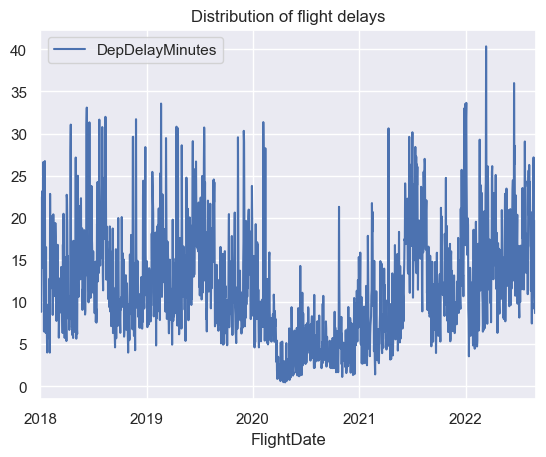

In [21]:
(df_flights
 .groupby("FlightDate")
 [["DepDelayMinutes"]]
 .mean()
 .plot(title="Distribution of flight delays"))


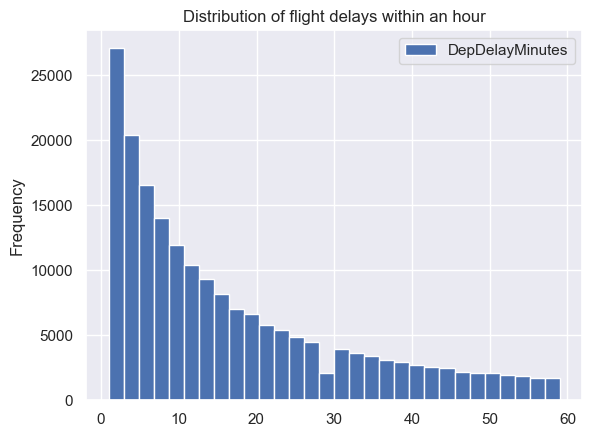

In [22]:
(df_flights
 .query("DepDelayMinutes > 0 and DepDelayMinutes < 60")
 [["DepDelayMinutes"]]
 .plot(kind="hist", bins=30, title="Distribution of flight delays within an hour"))
plt.show()


In [23]:
px.line(df_flights
        .groupby("FlightDate")
        [["DepDelayMinutes"]]
        .mean()
        )


#### Flight Status Categories

Departure Delay Groups

In [24]:
# Departure Delay intervals until 180 mins
def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 15, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 15) & (df_flights["DepDelayMinutes"] <= 45), "DepDelayClass"] = "Delay15_45"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 45), "DepDelayClass"] = "Delay45_180"
    df_flights.loc[df_flights["Cancelled"], "DepDelayClass"] = "Cancelled"
    
DepDelay_Class(df_flights)

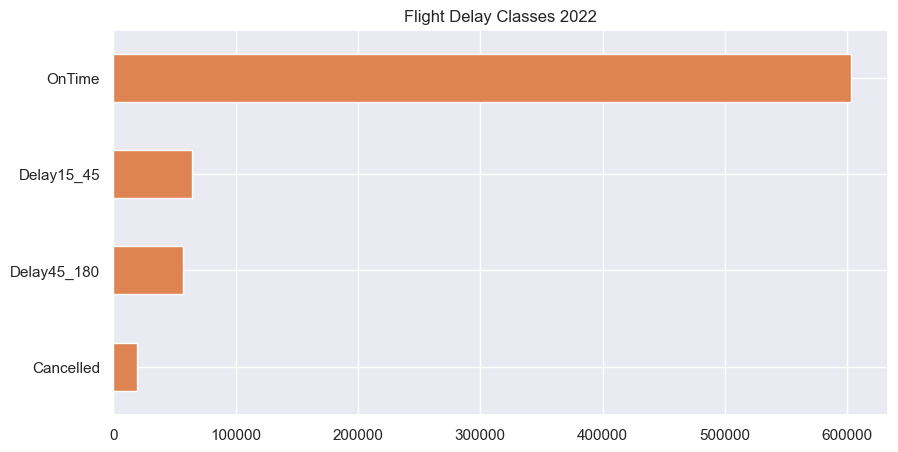

In [25]:
(df_flights
 .DepDelayClass
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Delay Classes 2022")
 )
plt.show()

In [26]:
df_flights["DepDelayClass"].value_counts()/ df_flights.shape[0]

OnTime         0.810666
Delay15_45     0.086453
Delay45_180    0.076359
Cancelled      0.026522
Name: DepDelayClass, dtype: float64

In [27]:
df_flights["Year"] = df_flights["FlightDate"].dt.year
df_flights_agg = df_flights.groupby("Year")["DepDelayClass"].value_counts().unstack()
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2018,2216,13493,11677,114383
2019,3787,18398,17347,162013
2020,7427,5695,4774,108343
2021,2825,14024,11925,129079
2022,3487,12743,11117,89621


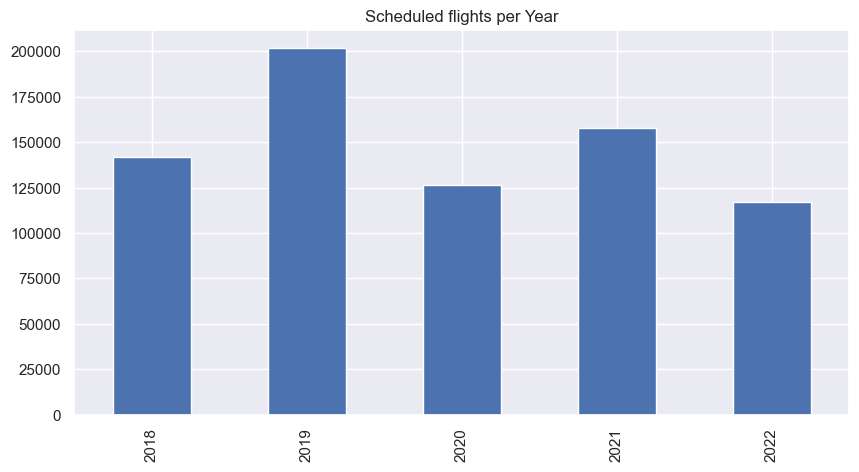

In [28]:
df_flights["Year"].value_counts().sort_index().plot(kind="bar", figsize=(10,5), title="Scheduled flights per Year")
plt.show()

<AxesSubplot: xlabel='Year', ylabel='count'>

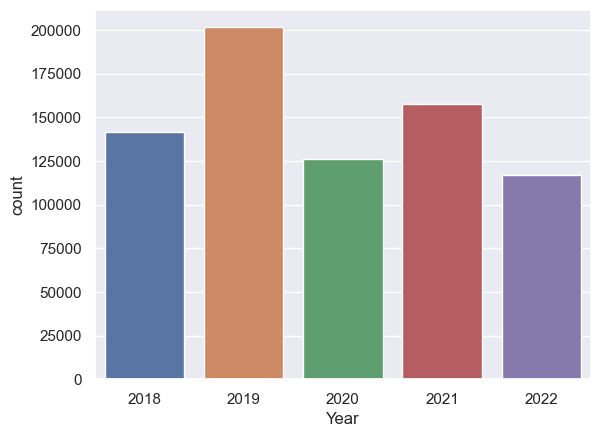

In [29]:
sns.countplot(x=df_flights["Year"])

In [30]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.groupby("Month")["DepDelayClass"].value_counts().unstack()
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
1,2012,5307,4691,55487
2,1774,5229,4539,47052
3,3835,5293,4344,56349
4,4291,5022,4311,49803
5,1126,5306,4558,47903
6,1204,6508,6207,46903
7,1122,6625,6681,52518
8,1575,6669,6627,55844
9,792,3670,3148,47585


Flights per month

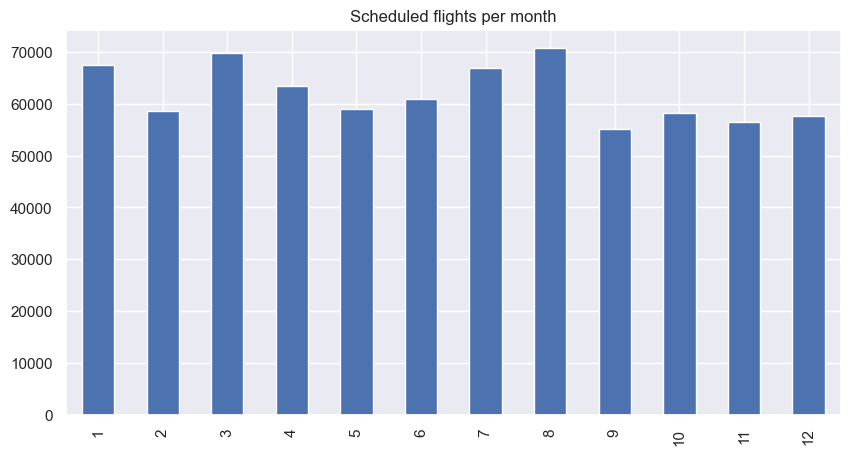

In [31]:
df_flights["Month"].value_counts().sort_index().plot(kind="bar", figsize=(10,5), title="Scheduled flights per month")
plt.show()

In [32]:
df_flights_agg.sum(axis=1)


Month
1     67497
2     58594
3     69821
4     63427
5     58893
6     60822
7     66946
8     70715
9     55195
10    58245
11    56501
12    57718
dtype: int64

In [33]:
df_flights.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,Year,Month
0,2018-01-08,Endeavor Air Inc.,N8883E,3305,10397,ATL,"Atlanta, GA",GA,Georgia,14108,PIA,"Peoria, IL",IL,Illinois,1001,0.0,0.0,0.0,0.0,1000-1059,0.0,0.0,0.0,1103,0.0,0.0,0.0,1100-1159,True,National Air System,False,122.0,0.0,565.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.62500,-84.4375,Cancelled,2018,1
1,2018-01-01,Endeavor Air Inc.,N917XJ,3306,10397,ATL,"Atlanta, GA",GA,Georgia,12266,IAH,"Houston, TX",TX,Texas,1151,1412.0,141.0,1.0,141.0,1100-1159,15.0,1522.0,24.0,1314,1546.0,152.0,1.0,1300-1359,False,none,False,143.0,115.0,689.0,141.0,0.0,11.0,0.0,0.0,0.0,0.0,33.62500,-84.4375,Delay45_180,2018,1
2,2018-01-09,Endeavor Air Inc.,N8886A,3308,11612,EVV,"Evansville, IN",IN,Indiana,11433,DTW,"Detroit, MI",MI,Michigan,1035,1027.0,-8.0,0.0,0.0,1000-1059,12.0,1236.0,15.0,1258,1251.0,0.0,0.0,1200-1259,False,none,False,83.0,57.0,363.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.03125,-87.5000,OnTime,2018,1
3,2018-01-06,Endeavor Air Inc.,N920XJ,3308,12339,IND,"Indianapolis, IN",IN,Indiana,13487,MSP,"Minneapolis, MN",MN,Minnesota,1330,1411.0,41.0,1.0,41.0,1300-1359,14.0,1450.0,3.0,1425,1453.0,28.0,1.0,1400-1459,False,none,False,115.0,85.0,503.0,28.0,0.0,0.0,0.0,0.0,1343.0,12.0,39.71875,-86.3125,Delay15_45,2018,1
4,2018-01-02,Endeavor Air Inc.,N915XJ,3312,10781,BTR,"Baton Rouge, LA",LA,Louisiana,10397,ATL,"Atlanta, GA",GA,Georgia,1840,1834.0,-6.0,0.0,0.0,1800-1859,9.0,2044.0,17.0,2121,2100.0,0.0,0.0,2100-2159,False,none,False,101.0,61.0,448.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.53125,-91.1250,OnTime,2018,1


In [ ]:
# Factors affecting delay
# Assumption: A flight is counted as "on time" if it operated less than 15 minutes later than the
def flight_status(df_flights):
        df_flights["FlightStatus"]="OnTime"

        df_flights.loc[df_flights["DepDel15"] == 0, "FlightStatus"]="OnTime"
        df_flights.loc[(df_flights["DepDelayMinutes"] >= 0) & (df_flights["DepDelayMinutes"] <= 15), "FlightStatus"]="OnTime"
        df_flights.loc[df_flights["WeatherDelay"] > 15, "FlightStatus"]="WeatherDelay"
        df_flights.loc[df_flights["NASDelay"] > 15, "FlightStatus"]="NASDelay"
        df_flights.loc[df_flights["SecurityDelay"] > 15, "FlightStatus"]="SecurityDelay"
        df_flights.loc[df_flights["LateAircraftDelay"] > 15, "FlightStatus"]="LateAircraftDelay"
        df_flights.loc[df_flights["CarrierDelay"] > 15, "FlightStatus"]="CarrierDelay"
        df_flights.loc[df_flights["Cancelled"], "FlightStatus"]="Cancelled"
    

flight_status(df_flights)

## Percentage of Flight results by Year

In [36]:
df_agg = (df_flights
 .groupby([df_flights["FlightDate"].dt.year])
 [["DepDelayClass"]]
 .value_counts(normalize=True)
 .unstack()*100
 )
df_agg.style.background_gradient(cmap="Greens")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
FlightDate,,,,
2018,1.563106,9.517596,8.236638,80.682660
2019,1.878985,9.128482,8.607011,80.385522
2020,5.883285,4.511284,3.781716,85.823715
2021,1.789640,8.884215,7.554497,81.771648
2022,2.981157,10.894433,9.504309,76.620101


In [37]:
df_agg = (df_flights
 .groupby([df_flights["FlightDate"].dt.month, "Operating_Airline"])
 [["FlightStatus"]]
 .value_counts()
 .unstack()
 )
df_agg.style.background_gradient(cmap="Greens")

In [38]:
df_agg = (df_flights
 .groupby([df_flights["FlightDate"].dt.year, "Operating_Airline"])
 [["FlightStatus"]]
 .value_counts(normalize=True)
 .unstack()
 )
df_agg.style.background_gradient(cmap="Greens")

In [39]:
#df_flights.loc[df_flights["ArrTime"] == 0]

In [40]:
(df_flights["FlightStatus"].value_counts())/df_flights.shape[0]

OnTime               0.819522
CarrierDelay         0.055529
LateAircraftDelay    0.054688
NASDelay             0.038807
Cancelled            0.026522
WeatherDelay         0.004570
SecurityDelay        0.000363
Name: FlightStatus, dtype: float64

In [41]:
df_flights["FlightStatus"].value_counts()

OnTime               610031
CarrierDelay          41334
LateAircraftDelay     40708
NASDelay              28887
Cancelled             19742
WeatherDelay           3402
SecurityDelay           270
Name: FlightStatus, dtype: int64

In [42]:
df_flights.columns.to_list()

['FlightDate',
 'Operating_Airline',
 'Tail_Number',
 'Flight_Number',
 'OriginAirportID',
 'Origin',
 'OriginCityName',
 'OriginState',
 'OriginStateName',
 'DestAirportID',
 'Dest',
 'DestCityName',
 'DestState',
 'DestStateName',
 'CRSDepTime',
 'DepTime',
 'DepDelay',
 'DepDel15',
 'DepDelayMinutes',
 'DepTimeBlk',
 'TaxiOut',
 'WheelsOn',
 'TaxiIn',
 'CRSArrTime',
 'ArrTime',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrTimeBlk',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CRSElapsedTime',
 'AirTime',
 'Distance',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'FirstDepTime',
 'TotalAddGTime',
 'latitude',
 'longitude',
 'DepDelayClass',
 'Year',
 'Month',
 'FlightStatus']

In [43]:
df_flights.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,Year,Month,FlightStatus
0,2018-01-08,Endeavor Air Inc.,N8883E,3305,10397,ATL,"Atlanta, GA",GA,Georgia,14108,PIA,"Peoria, IL",IL,Illinois,1001,0.0,0.0,0.0,0.0,1000-1059,0.0,0.0,0.0,1103,0.0,0.0,0.0,1100-1159,True,National Air System,False,122.0,0.0,565.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.62500,-84.4375,Cancelled,2018,1,Cancelled
1,2018-01-01,Endeavor Air Inc.,N917XJ,3306,10397,ATL,"Atlanta, GA",GA,Georgia,12266,IAH,"Houston, TX",TX,Texas,1151,1412.0,141.0,1.0,141.0,1100-1159,15.0,1522.0,24.0,1314,1546.0,152.0,1.0,1300-1359,False,none,False,143.0,115.0,689.0,141.0,0.0,11.0,0.0,0.0,0.0,0.0,33.62500,-84.4375,Delay45_180,2018,1,CarrierDelay
2,2018-01-09,Endeavor Air Inc.,N8886A,3308,11612,EVV,"Evansville, IN",IN,Indiana,11433,DTW,"Detroit, MI",MI,Michigan,1035,1027.0,-8.0,0.0,0.0,1000-1059,12.0,1236.0,15.0,1258,1251.0,0.0,0.0,1200-1259,False,none,False,83.0,57.0,363.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.03125,-87.5000,OnTime,2018,1,OnTime
3,2018-01-06,Endeavor Air Inc.,N920XJ,3308,12339,IND,"Indianapolis, IN",IN,Indiana,13487,MSP,"Minneapolis, MN",MN,Minnesota,1330,1411.0,41.0,1.0,41.0,1300-1359,14.0,1450.0,3.0,1425,1453.0,28.0,1.0,1400-1459,False,none,False,115.0,85.0,503.0,28.0,0.0,0.0,0.0,0.0,1343.0,12.0,39.71875,-86.3125,Delay15_45,2018,1,CarrierDelay
4,2018-01-02,Endeavor Air Inc.,N915XJ,3312,10781,BTR,"Baton Rouge, LA",LA,Louisiana,10397,ATL,"Atlanta, GA",GA,Georgia,1840,1834.0,-6.0,0.0,0.0,1800-1859,9.0,2044.0,17.0,2121,2100.0,0.0,0.0,2100-2159,False,none,False,101.0,61.0,448.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.53125,-91.1250,OnTime,2018,1,OnTime


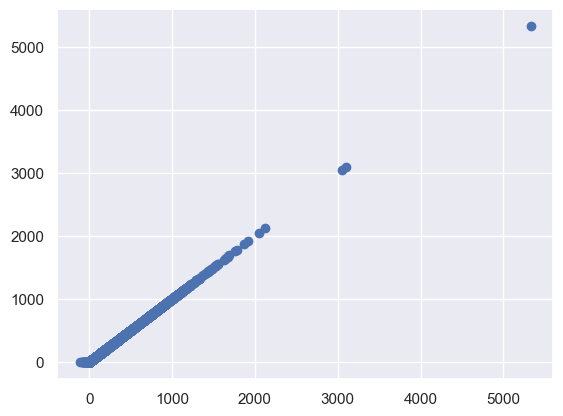

In [44]:
plt.scatter(df_flights["DepDelay"], df_flights["DepDelayMinutes"])

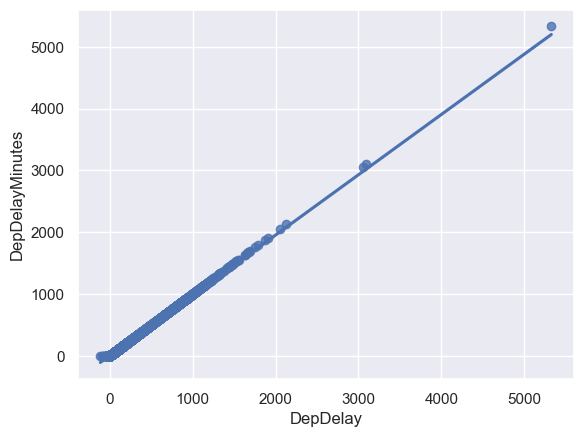

In [45]:
sns.regplot(x="DepDelay", y="DepDelayMinutes", data=df_flights)
plt.show()

In [46]:
(df_flights
 [["FlightStatus"]]
 .value_counts()
 .sort_values(ascending=False)
 .to_frame("Row Count")
 )

,Row Count
FlightStatus,
OnTime,610031
CarrierDelay,41334
LateAircraftDelay,40708
NASDelay,28887
Cancelled,19742
WeatherDelay,3402
SecurityDelay,270


#### Correlation [Pearson]

In [47]:
corr = (df_flights
        .select_dtypes('float16')
        .corr())
corr.style.background_gradient(cmap='coolwarm')


,DepTime,DepDelay,DepDel15,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,ArrTime,ArrDelayMinutes,ArrDel15,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude
DepTime,1.000000,0.123945,0.217962,0.122436,0.115011,0.730810,0.045054,0.706544,0.112938,0.188697,-0.015734,0.077429,-0.007896,0.034278,0.014530,0.053040,0.004217,0.121699,0.038901,0.018977,-0.033712,-0.005437
DepDelay,0.123945,1.000000,0.568522,0.996989,0.061935,0.037880,0.019854,0.031693,0.971015,0.519652,0.017222,0.018694,0.014274,0.699436,0.291901,0.284189,0.040666,0.598236,0.197649,0.206993,-0.004748,0.025744
DepDel15,0.217962,0.568522,1.000000,0.548619,0.075279,0.117987,0.012721,0.109022,0.502991,0.741106,0.024105,0.036151,0.024024,0.280649,0.107763,0.201019,0.029753,0.392902,0.150579,0.120716,-0.013013,0.024807
DepDelayMinutes,0.122436,0.996989,0.548619,1.000000,0.064138,0.037997,0.027080,0.032252,0.975174,0.503212,0.012249,0.016554,0.008629,0.705918,0.294952,0.282186,0.040561,0.598825,0.196928,0.207648,-0.001627,0.026169
TaxiOut,0.115011,0.061935,0.075279,0.064138,1.000000,0.135328,0.076746,0.131389,0.165513,0.272426,0.069147,0.104652,0.030484,0.037552,0.052428,0.285774,0.003361,0.045446,0.014821,0.021697,0.083042,0.102926
WheelsOn,0.730810,0.037880,0.117987,0.037997,0.135328,1.000000,0.074440,0.971308,0.039508,0.107799,0.025350,0.123152,0.026229,0.003067,0.002395,0.042807,0.003006,0.036233,-0.001177,-0.016574,-0.016963,-0.003542
TaxiIn,0.045054,0.019854,0.012721,0.027080,0.076746,0.074440,1.000000,0.077373,0.089591,0.137915,0.098568,0.119795,0.067922,0.014051,0.013565,0.180716,-0.000145,0.023500,0.000214,0.000950,-0.002525,0.049314
ArrTime,0.706544,0.031693,0.109022,0.032252,0.131389,0.971308,0.077373,1.000000,0.033723,0.099184,0.021376,0.118615,0.021574,0.001225,0.001594,0.039091,0.002684,0.030809,-0.002524,-0.016953,-0.017077,-0.004638
ArrDelayMinutes,0.112938,0.971015,0.502991,0.975174,0.165513,0.039508,0.089591,0.033723,1.000000,0.543770,0.007948,0.025492,0.004664,0.703234,0.303786,0.366098,0.040016,0.591923,0.185153,0.197318,0.001898,0.028480
ArrDel15,0.188697,0.519652,0.741106,0.503212,0.272426,0.107799,0.137915,0.099184,0.543770,1.000000,0.020413,0.058064,0.020242,0.287419,0.108834,0.352308,0.031031,0.392480,0.131073,0.103977,-0.003193,0.029587


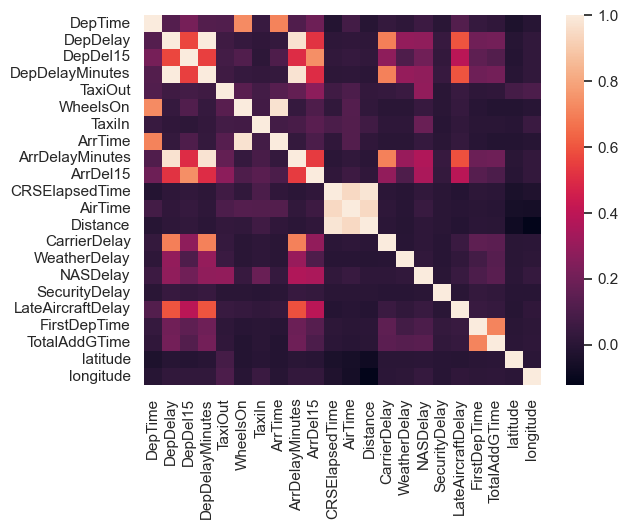

In [48]:
sns.heatmap(
    (df_flights
     .select_dtypes('float16')
     .corr()))
plt.show()


<AxesSubplot: xlabel='FlightDate'>

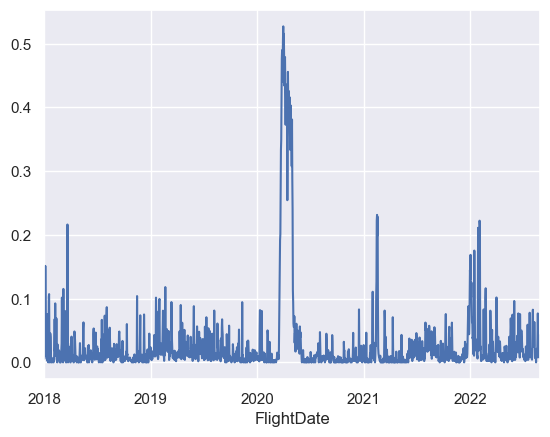

In [49]:
(df_flights.
 groupby("FlightDate")
 ["Cancelled"]
 .agg("mean")
 .plot()
 )


<AxesSubplot: xlabel='FlightDate'>

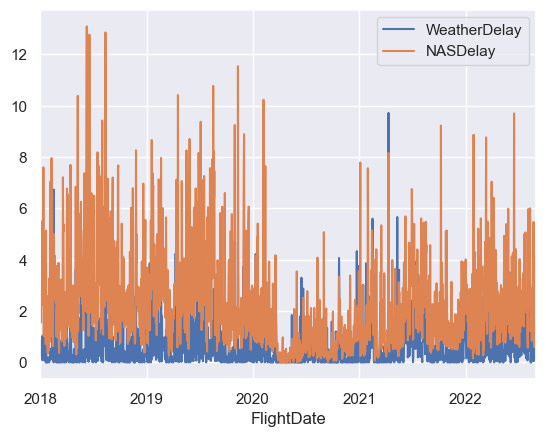

In [50]:
(df_flights.
 groupby("FlightDate")
 [["WeatherDelay", "NASDelay"]]
 .agg("mean")
 .plot())


<AxesSubplot: xlabel='FlightDate'>

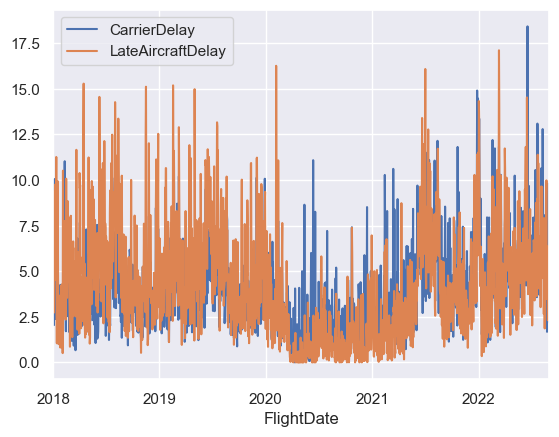

In [51]:
(df_flights.
 groupby("FlightDate")
 [["CarrierDelay", "LateAircraftDelay"]]
 .agg("mean")
 .plot())


##### Frequency Distribution Table

In [52]:
(df_flights
 [["Operating_Airline"]]
 .value_counts()
 .sort_values(ascending=False)
 .to_frame("Row Count")
 )


,Row Count
Operating_Airline,
Southwest Airlines Co.,139558
Delta Air Lines Inc.,84603
American Airlines Inc.,80481
SkyWest Airlines Inc.,80434
United Air Lines Inc.,60114
Republic Airlines,32717
JetBlue Airways,28359
Envoy Air,27392
Endeavor Air Inc.,25219


In [53]:
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Flights per airline",
    height=700,
)


In [54]:
df_flights.head(3)

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,Year,Month,FlightStatus
0,2018-01-08,Endeavor Air Inc.,N8883E,3305,10397,ATL,"Atlanta, GA",GA,Georgia,14108,PIA,"Peoria, IL",IL,Illinois,1001,0.0,0.0,0.0,0.0,1000-1059,0.0,0.0,0.0,1103,0.0,0.0,0.0,1100-1159,True,National Air System,False,122.0,0.0,565.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.62500,-84.4375,Cancelled,2018,1,Cancelled
1,2018-01-01,Endeavor Air Inc.,N917XJ,3306,10397,ATL,"Atlanta, GA",GA,Georgia,12266,IAH,"Houston, TX",TX,Texas,1151,1412.0,141.0,1.0,141.0,1100-1159,15.0,1522.0,24.0,1314,1546.0,152.0,1.0,1300-1359,False,none,False,143.0,115.0,689.0,141.0,0.0,11.0,0.0,0.0,0.0,0.0,33.62500,-84.4375,Delay45_180,2018,1,CarrierDelay
2,2018-01-09,Endeavor Air Inc.,N8886A,3308,11612,EVV,"Evansville, IN",IN,Indiana,11433,DTW,"Detroit, MI",MI,Michigan,1035,1027.0,-8.0,0.0,0.0,1000-1059,12.0,1236.0,15.0,1258,1251.0,0.0,0.0,1200-1259,False,none,False,83.0,57.0,363.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.03125,-87.5000,OnTime,2018,1,OnTime


In [55]:
(df_flights.
 groupby(["Flight_Number", "Tail_Number", "OriginCityName","DestCityName" ])
[["DepDelayMinutes"]]
#.agg(["mean", "sum"]).head(20)
)


In [56]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights
 .loc[df_flights["DepDelayMinutes"] >10, cols ]
 .sort_values(by=["Flight_Number", "FlightDate", "CRSDepTime"],ascending=[True, True, True]))

,FlightDate,Tail_Number,Flight_Number,Operating_Airline,OriginCityName,DestCityName,CRSDepTime,DepTime,DepDelayMinutes,AirTime,FlightStatus
2885,2018-01-02,N514AS,1,Alaska Airlines Inc.,"Washington, DC","Seattle, WA",800,813.0,13.0,321.0,OnTime
10175,2018-01-22,N8673F,1,Southwest Airlines Co.,"Houston, TX","San Diego, CA",855,945.0,50.0,194.0,CarrierDelay
30663,2018-04-17,N396HA,1,Hawaiian Airlines Inc.,"Los Angeles, CA","Honolulu, HI",700,717.0,17.0,338.0,OnTime
33839,2018-04-28,N905JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1011,1041.0,30.0,154.0,OnTime
59845,2018-07-04,N913JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1030,1132.0,62.0,137.0,LateAircraftDelay
59846,2018-07-18,N975JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1058,1115.0,17.0,168.0,CarrierDelay
103601,2018-10-29,N378HA,1,Hawaiian Airlines Inc.,"Los Angeles, CA","Honolulu, HI",700,721.0,21.0,317.0,OnTime
124430,2018-11-27,N381HA,1,Hawaiian Airlines Inc.,"Los Angeles, CA","Honolulu, HI",700,711.0,11.0,336.0,CarrierDelay
208010,2019-05-21,N209WN,1,Southwest Airlines Co.,"Houston, TX","Corpus Christi, TX",845,920.0,35.0,37.0,CarrierDelay
219481,2019-05-24,N526AS,1,Alaska Airlines Inc.,"Washington, DC","Seattle, WA",800,818.0,18.0,336.0,CarrierDelay


In [57]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights[cols]
 .groupby(["Flight_Number", "Operating_Airline"])
 [["DepDelayMinutes"]]
 .mean())

DepDelayMinutes
Flight_Number Operating_Airline                                         
1             Air Wisconsin Airlines Corp                            NaN
              Alaska Airlines Inc.                              1.800000
              Allegiant Air                                     0.000000
              American Airlines Inc.                            9.555555
              Cape Air                                               NaN
              Capital Cargo International                            NaN
              Comair Inc.                                            NaN
              Commutair Aka Champlain Enterprises, Inc.              NaN
              Compass Airlines                                       NaN
              Delta Air Lines Inc.                                   NaN
...                                                                  ...
9679          JetBlue Airways                                        NaN
              Mesa Airlines Inc.                                     NaN
              Peninsula Airways Inc.                                 NaN
              Republic Airlines                                 0.000000
              SkyWest Airlines Inc.                                  NaN
              Southwest Airlines Co.                                 NaN
              Spirit Air Lines                                       NaN
              Trans States Airlines                                  NaN
              United Air Lines Inc.                                  NaN
              Virgin America                                         NaN

[198744 rows x 1 columns]

In [58]:
col2 = ["CarrierDelay","WeatherDelay",	"NASDelay",	"SecurityDelay","LateAircraftDelay", "FirstDepTime", "TotalAddGTime", "latitude", "longitude", "DepDelayClass"]
cols = ["FlightDate","CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]	

Modelling

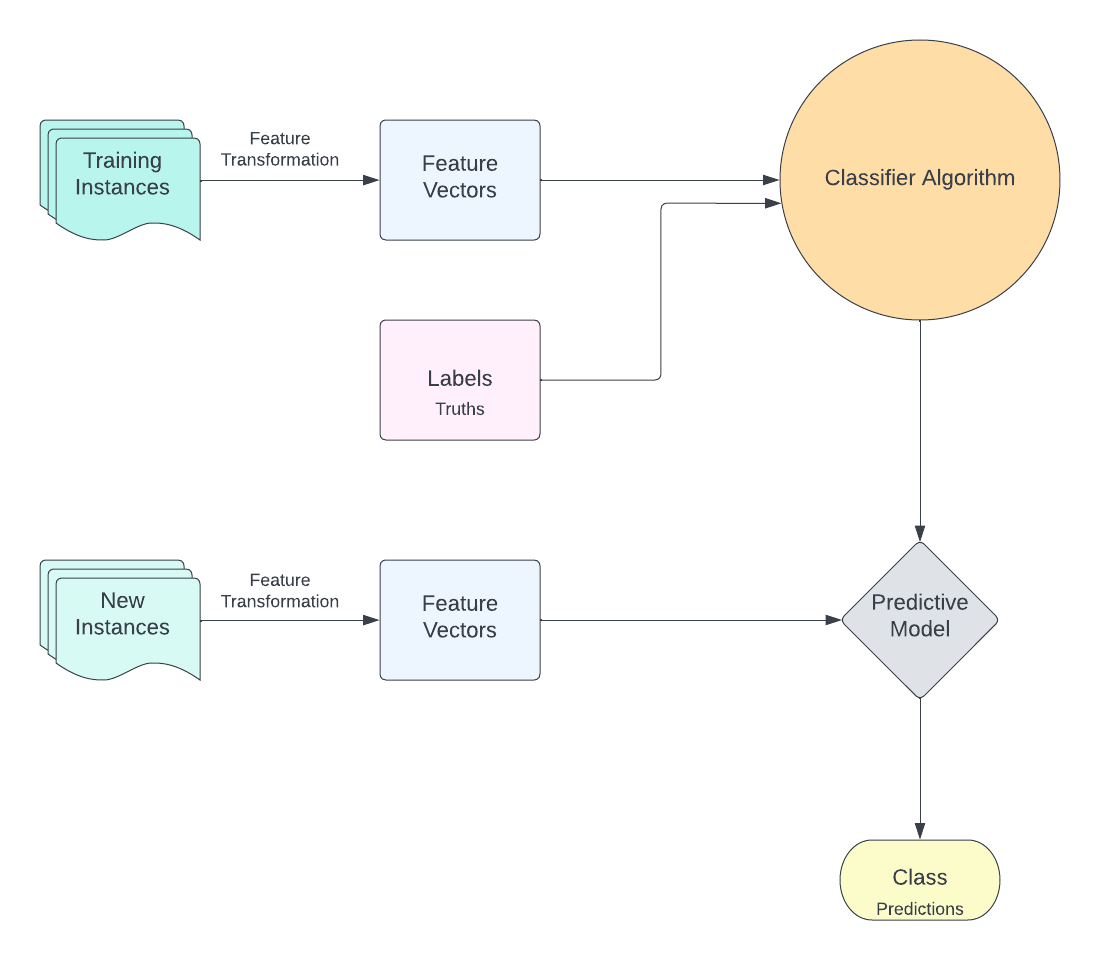

In [59]:
Image("../../data/images/ModellingWorkflow.png")

In [60]:
def fit_and_evaluate(X, y, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    kf = KFold(n_splits = 12, shuffle=True)
    
    for train, test in kf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        
        estimator = model(**kwargs) 
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(X, y)